In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# prompt: unzip zip in /content/Original Image.zip into /content/dataset/ python code

import zipfile
import os

# Define the paths
zip_file_path = "/content/drive/MyDrive/Original Image.zip"
extract_path = "/content/dataset/"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Open the zip file
try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to the specified directory
    zip_ref.extractall(extract_path)
    print(f"Successfully extracted {zip_file_path} to {extract_path}")
except FileNotFoundError:
  print(f"Error: The zip file '{zip_file_path}' was not found.")
except zipfile.BadZipFile:
  print(f"Error: The file '{zip_file_path}' appears to be a corrupted zip file.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")


Successfully extracted /content/drive/MyDrive/Original Image.zip to /content/dataset/


In [7]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import rotate
from PIL import Image, ImageOps
import matplotlib.pyplot as plt



# Function to perform transformations
def rotate_image(image, rotation_type):
    image_tensor = transforms.ToTensor()(image).unsqueeze(0)  # Convert to tensor and add batch dimension
    if rotation_type == "x":
        # Flip vertically (rotate along X-axis)
        transformed_tensor = torch.flip(image_tensor, [2])  # Flip along the height dimension
    elif rotation_type == "y":
        # Flip horizontally (rotate along Y-axis)
        transformed_tensor = torch.flip(image_tensor, [3])  # Flip along the width dimension
    elif rotation_type == "x_inverse":
        # Flip vertically and inverse (double flip along X and Y)
        transformed_tensor = torch.flip(image_tensor, [2, 3])  # Flip along both dimensions
    else:
        raise ValueError("Invalid rotation_type! Choose from ['x', 'y', 'x_inverse']")

    # Convert back to PIL image
    transformed_image = transforms.ToPILImage()(transformed_tensor.squeeze(0))
    return transformed_image

# Function to rotate by 90 degrees and crop back to original size
def rotate_and_crop(image, angle):
    rotated_image = rotate(image, angle=angle, expand=True)  # Rotate and expand canvas
    # Crop back to the original image dimensions
    original_width, original_height = image.size
    rotated_width, rotated_height = rotated_image.size

    # Calculate cropping box to center-crop the rotated image
    left = (rotated_width - original_width) // 2
    top = (rotated_height - original_height) // 2
    right = left + original_width
    bottom = top + original_height

    cropped_image = rotated_image.crop((left, top, right, bottom))
    return cropped_image


In [5]:
import os
folder_path = '/content/dataset/Original Image'

folders = os.listdir(folder_path)
for folder in folders:
  print(folder)
  # create folder in /content/dataset/Augmented Image if not exists
  if not os.path.exists(os.path.join('/content/dataset/Augmented Image', folder)):
    os.makedirs(os.path.join('/content/dataset/Augmented Image', folder))
  for file in os.listdir(os.path.join(folder_path, folder)):
    image_path = os.path.join(folder_path, folder, file)
    # augment image and save it into /content/dataset/Augmented Image
    image = Image.open(image_path)
    rotated_x = rotate_image(image, "x")
    rotated_y = rotate_image(image, "y")
    rotated_x_inverse = rotate_image(image, "x_inverse")
    rotated_90_cropped = rotate_and_crop(image, 90)
    rotated_x.save(os.path.join('/content/dataset/Augmented Image', folder, 'x_' + file))
    rotated_y.save(os.path.join('/content/dataset/Augmented Image', folder, 'y_' + file))
    rotated_x_inverse.save(os.path.join('/content/dataset/Augmented Image', folder, 'x_inverse_' + file))
    rotated_90_cropped.save(os.path.join('/content/dataset/Augmented Image', folder, '90_' + file))
    image.save(os.path.join('/content/dataset/Augmented Image', folder, file))

# import resnet152
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Pythium Fruit Rot
Fresh Leaf
Downy Mildew
Bacterial Wilt
Anthracnose
Belly Rot
Gummy Stem Blight
Fresh Cucumber


In [9]:
#import resnet152 for 8 categories
import torchvision
num_classes =  8
model = torchvision.models.resnet152(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 113MB/s]


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import os
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

model = model.to(device)

# split dataset into train and val 80/20
dataset = torchvision.datasets.ImageFolder(root='/content/dataset/Augmented Image', transform=preprocess)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Batch size 32
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/15
------------------------------


100%|██████████| 162/162 [04:21<00:00,  1.61s/it]


Train Loss: 0.4902, Train Accuracy: 0.8258


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Val Loss: 0.3300, Val Accuracy: 0.8836
Epoch 2/15
------------------------------


100%|██████████| 162/162 [04:13<00:00,  1.56s/it]


Train Loss: 0.2830, Train Accuracy: 0.9019


100%|██████████| 41/41 [01:00<00:00,  1.48s/it]


Val Loss: 0.4416, Val Accuracy: 0.8208
Epoch 3/15
------------------------------


100%|██████████| 162/162 [04:13<00:00,  1.56s/it]


Train Loss: 0.2701, Train Accuracy: 0.9071


100%|██████████| 41/41 [01:05<00:00,  1.60s/it]


Val Loss: 0.1720, Val Accuracy: 0.9372
Epoch 4/15
------------------------------


100%|██████████| 162/162 [04:12<00:00,  1.56s/it]


Train Loss: 0.1220, Train Accuracy: 0.9589


100%|██████████| 41/41 [00:59<00:00,  1.46s/it]


Val Loss: 0.9323, Val Accuracy: 0.7874
Epoch 5/15
------------------------------


100%|██████████| 162/162 [04:13<00:00,  1.56s/it]


Train Loss: 0.1840, Train Accuracy: 0.9374


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Val Loss: 0.3561, Val Accuracy: 0.8976
Epoch 6/15
------------------------------


100%|██████████| 162/162 [04:17<00:00,  1.59s/it]


Train Loss: 0.1055, Train Accuracy: 0.9630


100%|██████████| 41/41 [01:02<00:00,  1.53s/it]


Val Loss: 0.3035, Val Accuracy: 0.9139
Epoch 7/15
------------------------------


100%|██████████| 162/162 [04:13<00:00,  1.57s/it]


Train Loss: 0.1574, Train Accuracy: 0.9484


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Val Loss: 0.5895, Val Accuracy: 0.8805
Epoch 8/15
------------------------------


100%|██████████| 162/162 [04:12<00:00,  1.56s/it]


Train Loss: 0.0625, Train Accuracy: 0.9777


100%|██████████| 41/41 [01:01<00:00,  1.49s/it]


Val Loss: 0.3016, Val Accuracy: 0.9170
Epoch 9/15
------------------------------


100%|██████████| 162/162 [04:16<00:00,  1.58s/it]


Train Loss: 0.0912, Train Accuracy: 0.9699


100%|██████████| 41/41 [01:00<00:00,  1.48s/it]


Val Loss: 0.2740, Val Accuracy: 0.9162
Epoch 10/15
------------------------------


100%|██████████| 162/162 [04:12<00:00,  1.56s/it]


Train Loss: 0.0736, Train Accuracy: 0.9736


100%|██████████| 41/41 [01:00<00:00,  1.47s/it]


Val Loss: 0.2086, Val Accuracy: 0.9403
Epoch 11/15
------------------------------


100%|██████████| 162/162 [04:12<00:00,  1.56s/it]


Train Loss: 0.0467, Train Accuracy: 0.9843


100%|██████████| 41/41 [01:00<00:00,  1.46s/it]


Val Loss: 0.1266, Val Accuracy: 0.9597
Epoch 12/15
------------------------------


100%|██████████| 162/162 [04:12<00:00,  1.56s/it]


Train Loss: 0.0336, Train Accuracy: 0.9880


100%|██████████| 41/41 [01:00<00:00,  1.48s/it]


Val Loss: 0.2989, Val Accuracy: 0.9294
Epoch 13/15
------------------------------


100%|██████████| 162/162 [04:10<00:00,  1.55s/it]


Train Loss: 0.0638, Train Accuracy: 0.9796


100%|██████████| 41/41 [01:00<00:00,  1.49s/it]


Val Loss: 0.2250, Val Accuracy: 0.9302
Epoch 14/15
------------------------------


100%|██████████| 162/162 [04:10<00:00,  1.54s/it]


Train Loss: 0.0866, Train Accuracy: 0.9717


100%|██████████| 41/41 [01:00<00:00,  1.48s/it]


Val Loss: 0.3505, Val Accuracy: 0.9178
Epoch 15/15
------------------------------


100%|██████████| 162/162 [04:09<00:00,  1.54s/it]


Train Loss: 0.1285, Train Accuracy: 0.9610


100%|██████████| 41/41 [01:01<00:00,  1.49s/it]


Val Loss: 0.1982, Val Accuracy: 0.9387


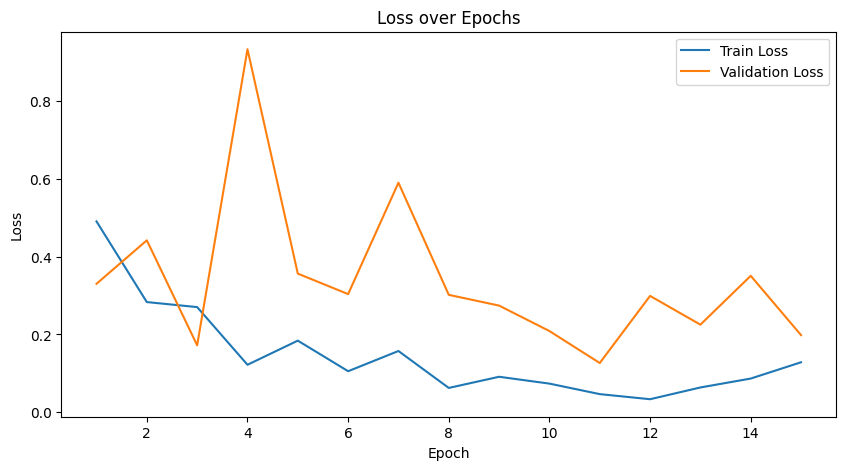

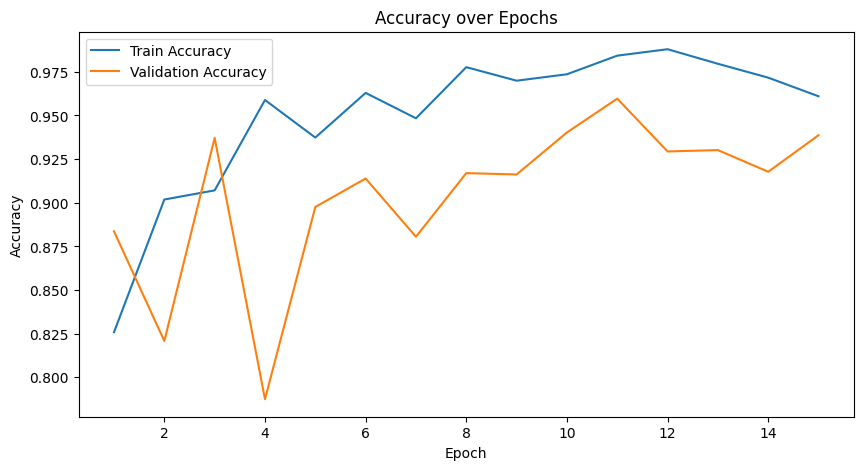

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm  # For progress bars

# Assuming train_loader and val_loader are already created

# Define the model (e.g., ResNet18 as an example)
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)  # Assuming 8 categories in your dataset

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
num_epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 30)

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plot losses and accuracies
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


100%|██████████| 41/41 [01:07<00:00,  1.65s/it]


Validation F1 Score: 0.9382


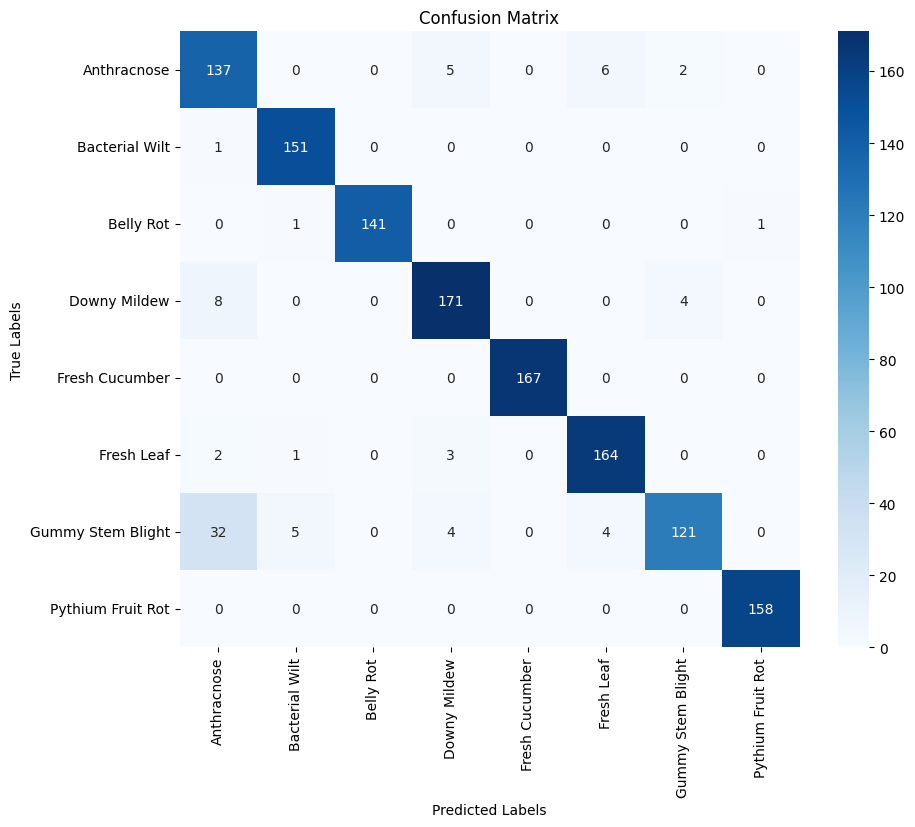

In [14]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # For better heatmap visualization

# Ensure model is in evaluation mode
model.eval()

# Collect predictions and labels
val_preds = []
val_labels = []

# Disable gradient calculations
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the predicted class

        # Store predictions and labels
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Compute the F1 score
val_f1 = f1_score(val_labels, val_preds, average='weighted')  # Weighted average for multi-class
print(f"Validation F1 Score: {val_f1:.4f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [15]:
torch.save(model.state_dict(), '/content/model.pth')
